# Train and Improve an Language Model with PyTorch

## Set up

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import os
from datetime import datetime
import math
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##  Training a Language Model with RNNs and LSTMs

### Dataset and Preprocessing

In [2]:
# Read the training, validation, and testing files, and replace newlines with the "<eos>" token.
def read_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
        lines = [line.split() + ['<eos>'] for line in lines]
        return lines
ptb_train_lines = read_file('penn-treebank/ptb.train.txt')
ptb_valid_lines = read_file('penn-treebank/ptb.valid.txt')
ptb_test_lines = read_file('penn-treebank/ptb.test.txt')
print(len(ptb_train_lines))
print(ptb_train_lines[:5])

42068
[['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', '<eos>'], ['pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N', '<eos>'], ['mr.', '<unk>', 'is', 'chairman', 'of', '<unk>', 'n.v.', 'the', 'dutch', 'publishing', 'group', '<eos>'], ['rudolph', '<unk>', 'N', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate', '<eos>'], ['a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', 'to', 'it', 'more', 'than', 'N', 'years', 'ago

### DataLoader

In [3]:
# Concatenate all articles in the training set into one long sequence.
ptb_train_tokens = [token for line in ptb_train_lines for token in line]
print(len(ptb_train_tokens))
print(ptb_train_tokens[:100])

929589
['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', '<eos>', 'pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N', '<eos>', 'mr.', '<unk>', 'is', 'chairman', 'of', '<unk>', 'n.v.', 'the', 'dutch', 'publishing', 'group', '<eos>', 'rudolph', '<unk>', 'N', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate', '<eos>', 'a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of']


In [4]:
# Generate batches with shape (batch size, sequence_length + 1).
# Continuous Batching
# use PyTorch's DataLoader class but overwrite the "iter" method.
# The "iter" method is called when we use a for loop to iterate over the DataLoader object.
# We will overwrite this method to return a generator that yields batches of data.
# The "init_epoch" method is called at the end of each epoch to shuffle the data.
# The "shuffle_batches" method shuffles the batches.
# The "__len__" method returns the number of batches in the dataset.
# The "__getitem__" method returns a batch of data given an index.

class PennTreebankDataset(Dataset):
    def __init__(self, data_lines, sequence_length, batch_size):
        self.data_lines = data_lines
        self.data = None
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.split_length = None
        self.init_epoch()

    def __len__(self):
        return self.split_length  // self.sequence_length * self.batch_size
    
    def __getitem__(self, idx):
        # Split the long sequence into batch size equal-length sequences
        # For each split sequence, cut them into continuous parts
        # Batch k is composed of the kth part of all the sequences.
        batch_x = idx % self.batch_size
        batch_y = idx // self.batch_size
        inputs = self.data[batch_x * self.split_length + batch_y*self.sequence_length: batch_x * self.split_length + (batch_y+1)*self.sequence_length]
        outputs = self.data[batch_x * self.split_length + batch_y*self.sequence_length + 1: batch_x * self.split_length + (batch_y+1)*self.sequence_length + 1]
        return inputs, outputs
    
    def init_epoch(self):
        self.data = self.shuffle_lines(self.data_lines)
        self.split_length = len(self.data) // self.batch_size

    def shuffle_lines(self, data_lines):
        np.random.shuffle(data_lines)
        data = [token for line in data_lines for token in line]
        return self.tensor_from_tokens(data)
    
    def tensor_from_tokens(self, tokens):
        token_ids = [vocab[token] for token in tokens]
        return torch.tensor(token_ids, dtype=torch.long, device=device)
    

### Word Embedding Initialization

In [5]:
# Initialize the word embeddings with Glove 
print('Loading Glove embeddings...')
vocab = {}
glove_embeddings = []
with open('glove.6B/glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        line = line.strip().split()
        vocab[line[0]] = len(vocab)
        glove_embeddings.append([float(x) for x in line[1:]])
print('Done.')
glove_embeddings = torch.tensor(glove_embeddings, dtype=torch.float, device=device)
print(glove_embeddings.shape)
print(glove_embeddings[0])

Loading Glove embeddings...
Done.
torch.Size([400000, 300])
tensor([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
         1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
         2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
         1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
         2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
        -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6

In [6]:
# For words not found in Glove, use random initializations.
for token in ptb_train_tokens:
    if token not in vocab.keys():
        vocab[token] = len(vocab)
        glove_embeddings = torch.cat((glove_embeddings, torch.randn(1, glove_embeddings.shape[1], device=device)), dim=0)

In [7]:
# test the vocab and dataloader
ptb_train_dataset = PennTreebankDataset(ptb_train_lines, 5, 10)
print(ptb_train_dataset.data_lines[:5])
print(ptb_train_dataset.data[:20])
print(ptb_train_dataset[0])

[['yet', 'the', 'soviet', 'leader', "'s", '<unk>', 'to', '<unk>', 'on', 'foreign', 'visits', 'and', 'steady', 'accumulation', 'of', 'personal', 'power', 'particularly', 'since', 'the', 'last', 'politburo', '<unk>', 'on', 'sept.', 'N', 'do', 'not', 'suggest', 'that', 'mr.', 'gorbachev', 'is', 'on', 'the', 'verge', 'of', 'being', '<unk>', 'nor', 'does', 'he', 'look', 'likely', 'to', 'reverse', 'the', 'powers', 'of', 'perestroika', '<eos>'], ['pulp', 'and', 'paper', 'performance', 'depends', 'on', 'cost', 'and', 'price', '<unk>', 'the', 'company', 'said', '<eos>'], ['serial', 'bonds', 'were', 'priced', 'to', 'yield', 'from', 'N', 'N', 'in', 'N', 'to', 'N', 'N', 'in', 'N', '<eos>'], ['charles', 'o.', '<unk>', 'of', 'mount', '<unk>', 'ind.', 'investment', 'broker', '<unk>', 'and', 'son', 'of', 'a', 'former', 'stable', 'owner', '<unk>', 'tennessee', 'walking', 'horses', 'for', 'six', 'years', 'raised', 'cattle', 'for', 'four', 'and', 'never', 'made', 'a', 'profit', 'on', 'either', '<eos>'], 

### Training and Generating 

In [8]:
# Train and Test an LSTM Language Model
class LSTM_LM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob, glove_embeddings, tie_weight=False):
        super(LSTM_LM, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(glove_embeddings)
        self.embedding.weight.requires_grad = False
        self.dropout = nn.Dropout(self.dropout_prob)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, self.num_layers, dropout=self.dropout_prob, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, self.vocab_size)
        if tie_weight:
            self.linear.weight = self.embedding.weight
            self.linear.weight.requires_grad = False
        self.softmax = nn.LogSoftmax(dim=2)


    def forward(self, inputs, hidden):
        embedding = self.embedding(inputs)
        embedding = self.dropout(embedding)
        lstm_out, hidden = self.lstm(embedding, hidden)
        lstm_out = self.dropout(lstm_out)
        outputs = self.linear(lstm_out)
        outputs = self.softmax(outputs)
        return outputs, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device),
                weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device))
        
    def reuse_hidden(self, hidden):
        return (hidden[0].detach(), hidden[1].detach())

In [9]:
# Train and Test an RNN Language Model
class RNN_LM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob, glove_embeddings):
        super(RNN_LM, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(glove_embeddings)
        self.embedding.weight.requires_grad = False
        self.dropout = nn.Dropout(self.dropout_prob)
        self.rnn = nn.RNN(self.embedding_dim, self.hidden_dim, self.num_layers, dropout=self.dropout_prob, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, self.vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)


    def forward(self, inputs, hidden):
        embedding = self.embedding(inputs)
        embedding = self.dropout(embedding)
        rnn_out, hidden = self.rnn(embedding, hidden)
        rnn_out = self.dropout(rnn_out)
        outputs = self.linear(rnn_out)
        outputs = self.softmax(outputs)
        return outputs, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device)
    
    def reuse_hidden(self, hidden):
        return hidden.detach()

In [10]:
# Train the model
def train(model, train_dataLoader, criterion, optimizer, reuse=True):
    model.train()
    epoch_loss = 0
    hidden = model.init_hidden(train_dataLoader.dataset.batch_size)
    for inputs, targets in train_dataLoader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        if reuse:
            hidden = model.reuse_hidden(hidden)
        else:
            hidden = model.init_hidden(train_dataLoader.dataset.batch_size)
        model.zero_grad()
        outputs, hidden = model(inputs, hidden)
        loss = criterion(outputs.view(-1, model.vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(train_dataLoader)

In [11]:
# Test the model
def test(model, test_dataLoader, criterion):
    model.eval()
    epoch_loss = 0
    hidden = model.init_hidden(test_dataLoader.dataset.batch_size)
    with torch.no_grad():
        for inputs, targets in test_dataLoader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs.view(-1, model.vocab_size), targets.view(-1))
            epoch_loss += loss.item()
    return epoch_loss / len(test_dataLoader)

In [23]:
# args
args = {
    'vocab_size': len(vocab),
    'embedding_dim': 300,
    'hidden_dim': 300,
    'num_layers': 2,
    'dropout_prob': 0.5,
    'shuffle': False,
    'reuse_hidden': True,
    'tie_weight': False,
    'glove_embeddings': glove_embeddings,
    'lr': 0.001,
    'epochs': 30,
    'batch_size': 32,
    'sequence_length': 7,
    'save_path': 'assets/'
}

In [18]:
## Train 
train_dataLoader = DataLoader(dataset=PennTreebankDataset(ptb_train_lines, args['sequence_length'], args['batch_size']), batch_size=args['batch_size'], shuffle=args['shuffle'])
valid_dataLoader = DataLoader(dataset=PennTreebankDataset(ptb_valid_lines, args['sequence_length'], args['batch_size']), batch_size=args['batch_size'], shuffle=False)
model = LSTM_LM(args['vocab_size'], args['embedding_dim'], args['hidden_dim'], args['num_layers'], args['dropout_prob'], args['glove_embeddings'], args['tie_weight'])
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=args['lr'])
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
train_losses = []
valid_losses = []
for epoch in range(args['epochs']):
    train_dataLoader.dataset.init_epoch()
    train_loss = train(model, train_dataLoader, criterion, optimizer, reuse=args['reuse_hidden'])
    valid_loss = test(model, valid_dataLoader, criterion)
    # scheduler.step()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_perplexity = math.exp(valid_loss)
    print('Epoch: {}, Train Loss: {}, Valid Loss: {}, Valid Perplexity: {}'.format(epoch, train_loss, valid_loss, valid_perplexity))


Epoch: 0, Train Loss: 6.480832074975129, Valid Loss: 5.762116759743734, Valid Perplexity: 318.02079055401555
Epoch: 1, Train Loss: 5.710420229257403, Valid Loss: 5.410660904591569, Valid Perplexity: 223.7794356749915
Epoch: 2, Train Loss: 5.478890330166839, Valid Loss: 5.261354462354016, Valid Perplexity: 192.7423768710125
Epoch: 3, Train Loss: 5.347738359657705, Valid Loss: 5.158400906617881, Valid Perplexity: 173.88617293603917
Epoch: 4, Train Loss: 5.256110322823091, Valid Loss: 5.094207982524188, Valid Perplexity: 163.07463550202115
Epoch: 5, Train Loss: 5.186941137771257, Valid Loss: 5.045328573615356, Valid Perplexity: 155.29531676006445
Epoch: 6, Train Loss: 5.132461222604718, Valid Loss: 5.009516023212653, Valid Perplexity: 149.83220328996302
Epoch: 7, Train Loss: 5.086597706961844, Valid Loss: 4.978291694154131, Valid Perplexity: 145.22607906577343
Epoch: 8, Train Loss: 5.052335199777636, Valid Loss: 4.952496328614766, Valid Perplexity: 141.5278232668014
Epoch: 9, Train Loss: 

### Plot curves and save model

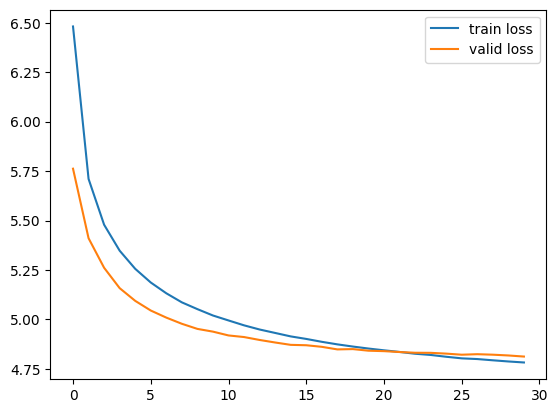

In [19]:
## plot the loss curve and save the model
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.legend()
## save with utc time
torch.save(model.state_dict(), args['save_path'] + 'models/LSTM_LM_layer3_seq7_' + datetime.utcnow().strftime("%Y-%m-%d-%H%MZ") + '.pt')
plt.savefig(args['save_path'] + 'curves/LSTM_layer3_seq7_loss_curve_' + datetime.utcnow().strftime("%Y-%m-%d-%H%MZ") + '.png')

In [24]:
## Test
test_dataLoader = DataLoader(dataset=PennTreebankDataset(ptb_test_lines, args['sequence_length'], args['batch_size']), batch_size=args['batch_size'], shuffle=False)
valid_dataLoader = DataLoader(dataset=PennTreebankDataset(ptb_valid_lines, args['sequence_length'], args['batch_size']), batch_size=args['batch_size'], shuffle=False)
model = LSTM_LM(args['vocab_size'], args['embedding_dim'], args['hidden_dim'], args['num_layers'], args['dropout_prob'], args['glove_embeddings'])
model.load_state_dict(torch.load(args['save_path'] + 'models/case3_LM_2023-10-24-0811Z.pt'))
model.to(device)
criterion = nn.NLLLoss()
test_loss = test(model, test_dataLoader, criterion)
valid_loss = test(model, valid_dataLoader, criterion)
test_perplexity = math.exp(test_loss)
valid_perplexity = math.exp(valid_loss)
print('Test Loss: {:.4f}, Valid Loss: {:.4f}, Test Perplexity: {:.4f}, Valid Perplexity: {:.4f}'.format(test_loss, valid_loss, test_perplexity, valid_perplexity))

Test Loss: 4.7069, Valid Loss: 4.7828, Test Perplexity: 110.7070, Valid Perplexity: 119.4334


### Generation

In [26]:
def generate(model, seed, length):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor([[vocab[token] for token in seed]]).to(device)
        outputs = [vocab[token] for token in seed]
        for i in range(length):
            hidden = model.init_hidden(1)
            output, hidden = model(inputs, hidden)
            output = output.view(-1, model.vocab_size)
            predict_prob = torch.exp(output[-1])
            sample = torch.multinomial(predict_prob, 1)
            outputs.append(sample.item())
            inputs = torch.tensor([outputs]).to(device)
            
    return ' '.join([list(vocab.keys())[list(vocab.values()).index(i)] for i in outputs])

In [27]:
best_model = LSTM_LM(args['vocab_size'], args['embedding_dim'], args['hidden_dim'], args['num_layers'], args['dropout_prob'], args['glove_embeddings'])
best_model.load_state_dict(torch.load(args['save_path'] + 'models/case3_LM_2023-10-24-0811Z.pt'))
best_model.to(device)
seed = ['the','company', 'will', 'charge', '$']
print(generate(best_model, seed, 20))

the company will charge $ N million <eos> rumors on <unk> does n't recall the size of the money <eos> mitsubishi all most oil valley


### Test generation model

In [ ]:
# for i in range(10):
#     sequence = input()
#     seed = sequence.strip().split()
#     print(generate(best_model,seed, 10))